### 1 Loading Dataset

In [1]:
import numpy as np
import random
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import os
import random
from torchvision import transforms

from models.my_datasets import MyDataset2
from models.my_models_alex import MyModel_CNN
#from models.my_models_alex import MyModel_CNN


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())
print(device)

True
cuda:0


In [4]:
'''
ROOT = './output/town04_image_data/images/'
OUT = './output/town04_image_data/smallimages/'
SIZE = (400,300)
image_paths = os.listdir(ROOT)
image_paths.sort()
for im in image_paths:
    #print(im)
    img = cv2.imread(ROOT+im)
    img = cv2.resize(img, SIZE,  interpolation = cv2.INTER_AREA)
    cv2.imwrite(OUT+im, img)
'''

"\nROOT = './output/town04_image_data/images/'\nOUT = './output/town04_image_data/smallimages/'\nSIZE = (400,300)\nimage_paths = os.listdir(ROOT)\nimage_paths.sort()\nfor im in image_paths:\n    #print(im)\n    img = cv2.imread(ROOT+im)\n    img = cv2.resize(img, SIZE,  interpolation = cv2.INTER_AREA)\n    cv2.imwrite(OUT+im, img)\n"

In [5]:
'''
#### delete the data for the unstored images
ROOT = './output/town04_image_data/'
out = open(ROOT+"alldata.txt",'w')
lines=[]
with open(ROOT+"offdata_image.txt", 'r') as infile:
    for line in infile:
        line = line.rstrip()
        words = line.split()
        img = cv2.imread(ROOT+words[0])
        if img is None:
            pass
        else:
            out.write(line)
            out.write('\r\n')
out.close()
'''

'\n#### delete the data for the unstored images\nROOT = \'./output/town04_image_data/\'\nout = open(ROOT+"alldata.txt",\'w\')\nlines=[]\nwith open(ROOT+"offdata_image.txt", \'r\') as infile:\n    for line in infile:\n        line = line.rstrip()\n        words = line.split()\n        img = cv2.imread(ROOT+words[0])\n        if img is None:\n            pass\n        else:\n            out.write(line)\n            out.write(\'\r\n\')\nout.close()\n'

In [6]:
'''
#### compute the delta imformation from the original information
ROOT = './output/town04_image_data/'
out = open(ROOT+"delta.txt",'w')
delta_data = np.empty((0,3))
with open(ROOT+"data_image_all.txt", 'r') as infile:
    for line in infile:
        line = line.rstrip()
        words = line.split()
        newline = np.array([[float(words[1])-float(words[2]), float(words[3]), float(words[4])]])
        delta_data = np.append(delta_data, newline, axis=0)
        
np.set_printoptions(threshold = np.inf)
out.write(str(repr(np.array(delta_data))))
out.close()
'''

'\n#### compute the delta imformation from the original information\nROOT = \'./output/town04_image_data/\'\nout = open(ROOT+"delta.txt",\'w\')\ndelta_data = np.empty((0,3))\nwith open(ROOT+"data_image_all.txt", \'r\') as infile:\n    for line in infile:\n        line = line.rstrip()\n        words = line.split()\n        newline = np.array([[float(words[1])-float(words[2]), float(words[3]), float(words[4])]])\n        delta_data = np.append(delta_data, newline, axis=0)\n        \nnp.set_printoptions(threshold = np.inf)\nout.write(str(repr(np.array(delta_data))))\nout.close()\n'

In [7]:
#preprocess the txt file
ROOT = './output/town04_data/trajectory1_pjx/'
train_out = open(ROOT+"traindata_shuffle.txt",'w')
val_out = open(ROOT+"valdata_shuffle.txt",'w')
over_out = open(ROOT+"overdata_shuffle.txt",'w')
lines=[]
with open(ROOT+"delta_5outs_CNN.txt", 'r') as infile:
    for line in infile:
        lines.append(line)
    random.shuffle(lines)
    num_train = np.ceil(0.85*len(lines))
    for count, line in enumerate(lines):
        if count <=num_train:
            if count>=25 and count<=35:
                print(line)
                over_out.write(line)
            train_out.write(line)
        else:
            val_out.write(line) 
train_out.close()            
val_out.close()
over_out.close()        

images_off/pjx_1_000470_06_03.png 4.939019407980143 4.067550942845005 8.042180663676135 -0.01331708538714338 -0.09387469737058485 0.9999999999999929 0.1148864519452058

images_off/pjx_1_000410_09_06.png 4.938853979025358 6.916371806204925 8.598970726711084 1.2952681744473011 0.36948051147195043 7.689932190753901e-16 0.12884707484625266

images_off/traj2_000040_10_05.png 5.349486221704329 4.671695539899523 7.1508423303283735 -1.0114434199224718 -0.3333914163290395 0.9999999999999998 0.12279470121900404

images_off/pjx_1_000190_03_17.png 4.9392810794068325 5.543134513236862 7.792073199822347 -0.4280866664921632 -0.12351035398098631 2.6863082667197584e-16 -0.056712241154498515

images_off/traj1_000290_07_02.png 4.93837194302824 4.143114481123035 9.523938877116223 -0.9452614955223453 0.13161608423280666 0.9999999999999171 -0.49742368896355504

images_off/pjx_1_000820_01_08.png 5.1393643126678095 5.680902030539136 7.79212054811569 -0.35152990641728366 -0.10503267654774497 3.718169676371676e

In [8]:
TRANSFORM = transforms.Compose([#transforms.Grayscale(num_output_channels=3),
                                transforms.ToTensor(),
                                #transforms.Normalize((0.5,), (0.5, ))])
                                transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])
SIZE = (128,128)
over_data = MyDataset2(root = ROOT, txtname = 'overdata_shuffle.txt', transform=TRANSFORM, size=SIZE)
train_data = MyDataset2(root = ROOT, txtname = 'traindata_shuffle.txt' , transform = TRANSFORM, size= SIZE)
val_data = MyDataset2(root = ROOT, txtname = 'valdata_shuffle.txt', transform = TRANSFORM, size= SIZE)
over_loader = DataLoader(dataset=over_data, batch_size=32, shuffle=True)
train_loader = DataLoader(dataset=train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(dataset=val_data, batch_size=32, shuffle=True)
print("Overfit size: %i" % len(over_data))
print("Train size: %i" % len(train_data))
print("Validation size: %i" % len(val_data))

Overfit size: 11
Train size: 53562
Validation size: 9450


In [9]:
print(over_data[0][0][0].shape)
cv2.imshow('Window',over_data[0][0][0])
cv2.waitKey(0)
cv2.destroyAllWindows()

torch.Size([3, 128, 128])


error: OpenCV(4.5.4) :-1: error: (-5:Bad argument) in function 'imshow'
> Overload resolution failed:
>  - mat is not a numpy array, neither a scalar
>  - Expected Ptr<cv::cuda::GpuMat> for argument 'mat'
>  - Expected Ptr<cv::UMat> for argument 'mat'


### 2 Defining Neural Network

In [10]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

In [11]:
mynet= MyModel_CNN().to(device)
print(mynet)

RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [37]:
#mynet.apply(init_weights)

In [38]:
total_params = sum(p.numel() for p in mynet.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in mynet.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} trainable parameters.')

2,486,597 total parameters.
2,486,597 trainable parameters.


### 3 Training Neural network

In [39]:
mycriterion = nn.MSELoss(reduction='mean') 
myoptimizer = optim.Adam(mynet.parameters(), lr=1e-6, eps = 1e-08) 

In [47]:
def run_epoch(model,criterion,optimizer,dataloader,iftrain):    
    running_loss1 = 0.0  
    running_loss2 = 0.0
    running_loss3 = 0.0  
    running_loss4 = 0.0
    running_loss5 = 0.0
    #Iterating through the minibatches of the data
    for i, data in enumerate(dataloader, 0): 
        X, y1, y2, y3, y4, y5 = data
        X = [x.cuda() for x in X]
        y1 = y1.to(device).float()
        y2 = y2.to(device).float()
        y3 = y3.to(device).float()
        y4 = y4.to(device).float()
        y5 = y5.to(device).float()
        #Y = [y.cuda() for y in Y]
        #X = torch.tensor(X)
        #Y = torch.as_tensor(np.array(Y))
        #print(X.shape)
        if iftrain:  
            optimizer.zero_grad()
            y_pred = model(X)
            y_pred1 = y_pred[:,0].float()
            y_pred2 = y_pred[:,1].float()
            y_pred3 = y_pred[:,2].float()
            y_pred4 = y_pred[:,3].float()
            y_pred5 = y_pred[:,4].float()
            loss1 = criterion(y_pred1, y1)
            loss2 = criterion(y_pred2, y2) 
            loss3 = criterion(y_pred3, y3)
            loss4 = criterion(y_pred4, y4) 
            loss5 = criterion(y_pred5, y5) 
            loss = loss1 + loss2 + loss3 + (loss4 + loss5)
            #print(y)
            #print(y_pred)
            loss.backward()             
            optimizer.step()            
            running_loss1 += loss1.item() 
            running_loss2 += loss2.item() 
            running_loss3 += loss3.item() 
            running_loss4 += loss4.item() 
            running_loss5 += loss5.item()
            #print('x', X[1])
            #print('prediction', y_pred1)
            #print('gt', y1)
        else:
            y_pred = y_pred = model(X)
            y_pred1 = y_pred[:,0].float()
            y_pred2 = y_pred[:,1].float()
            y_pred3 = y_pred[:,2].float()
            y_pred4 = y_pred[:,3].float()
            y_pred5 = y_pred[:,4].float()
            loss1 = criterion(y_pred1, y1)
            loss2 = criterion(y_pred2, y2)
            loss3 = criterion(y_pred3, y3)
            loss4 = criterion(y_pred4, y4) 
            loss5 = criterion(y_pred5, y5)
            loss = loss1 + loss2 + loss3 + (loss4 + loss5)
            running_loss1 += loss1.item() 
            running_loss2 += loss2.item() 
            running_loss3 += loss3.item() 
            running_loss4 += loss4.item() 
            running_loss5 += loss5.item()
    return running_loss1, running_loss2, running_loss3, running_loss4, running_loss5

In [48]:
# test if the model will overfit with only one sample
max_epochs = 600
train_history = np.empty([0, 5], dtype=float) 
val_history = np.empty([0, 5], dtype=float) 
myoptimizer = optim.Adam(mynet.parameters(), lr=1e-4, eps = 1e-08) 
#scheduler = optim.lr_scheduler.CosineAnnealingLR(myoptimizer, max_epochs)
for epoch in range(max_epochs): 
    '''
    if epoch >= 1999 and epoch <= 2999:
        myoptimizer.param_groups[0]['lr'] = 1e-5
    elif epoch > 2999:
        myoptimizer.param_groups[0]['lr'] = 1e-6
    scheduler.step()
    '''
    train_loss1, train_loss2, train_loss3, train_loss4, train_loss5 = run_epoch(model=mynet,criterion=mycriterion,
                           optimizer=myoptimizer,dataloader=over_loader,
                           iftrain=True)
    train_history = np.append(train_history, np.array([[train_loss1, train_loss2, train_loss3, train_loss4, train_loss5]]), axis=0)
    val_loss1, val_loss2, val_loss3, val_loss4, val_loss5 =  run_epoch(model=mynet,criterion=mycriterion,
                           optimizer=myoptimizer,dataloader=over_loader,
                           iftrain=False)
    val_history = np.append(val_history, np.array([[val_loss1, val_loss2, val_loss3, val_loss4, val_loss5]]), axis=0)
    if epoch % 10 == 9:
        print(f"Epoch {epoch + 1}/{max_epochs}")
        print('Delta X: train_loss: %2e, val_loss: %2e'%(train_loss1, val_loss1))
        print('Delta Y: train_loss: %2e, val_loss: %2e'%(train_loss2, val_loss2))
        print('Delta yaw: train_loss: %2e, val_loss: %2e'%(train_loss3, val_loss3))
        print('Throttle: train_loss: %2e, val_loss: %2e'%(train_loss4, val_loss4))
        print('Steering Angle: train_loss: %2e, val_loss: %2e'%(train_loss5, val_loss5))
        #print(scheduler.get_last_lr())

Epoch 10/600
Delta X: train_loss: 3.524752e+00, val_loss: 2.760947e+00
Delta Y: train_loss: 1.908681e+00, val_loss: 1.937792e+00
Delta yaw: train_loss: 3.269719e+00, val_loss: 2.207694e+00
Throttle: train_loss: 7.115465e-01, val_loss: 5.683656e-01
Steering Angle: train_loss: 2.989249e-01, val_loss: 2.852865e-01
Epoch 20/600
Delta X: train_loss: 1.027936e-01, val_loss: 9.268255e-02
Delta Y: train_loss: 7.550504e-01, val_loss: 7.558414e-01
Delta yaw: train_loss: 3.681460e-01, val_loss: 2.417771e-01
Throttle: train_loss: 1.676163e-01, val_loss: 1.646495e-01
Steering Angle: train_loss: 1.558968e-01, val_loss: 8.284579e-02
Epoch 30/600
Delta X: train_loss: 2.657750e-02, val_loss: 2.103204e-02
Delta Y: train_loss: 9.738187e-02, val_loss: 8.927441e-02
Delta yaw: train_loss: 6.433997e-02, val_loss: 6.427152e-02
Throttle: train_loss: 4.933986e-02, val_loss: 4.401823e-02
Steering Angle: train_loss: 4.473627e-02, val_loss: 6.611971e-02
Epoch 40/600
Delta X: train_loss: 1.867198e-02, val_loss: 1.4

Epoch 280/600
Delta X: train_loss: 5.167583e-13, val_loss: 6.201100e-13
Delta Y: train_loss: 2.865788e-13, val_loss: 6.865216e-14
Delta yaw: train_loss: 1.019450e-13, val_loss: 3.166419e-13
Throttle: train_loss: 1.708508e-13, val_loss: 2.767459e-13
Steering Angle: train_loss: 3.904425e-13, val_loss: 3.621823e-13
Epoch 290/600
Delta X: train_loss: 2.687144e-13, val_loss: 2.687144e-13
Delta Y: train_loss: 1.636872e-13, val_loss: 2.002641e-13
Delta yaw: train_loss: 2.877358e-13, val_loss: 2.595159e-13
Throttle: train_loss: 2.302730e-13, val_loss: 1.245040e-13
Steering Angle: train_loss: 1.534200e-13, val_loss: 1.599097e-13
Epoch 300/600
Delta X: train_loss: 2.273737e-13, val_loss: 8.268134e-14
Delta Y: train_loss: 2.285243e-13, val_loss: 2.086614e-13
Delta yaw: train_loss: 1.042058e-13, val_loss: 1.857567e-13
Throttle: train_loss: 2.038042e-13, val_loss: 1.323361e-13
Steering Angle: train_loss: 2.150878e-13, val_loss: 2.576497e-13
Epoch 310/600
Delta X: train_loss: 2.067033e-13, val_loss:

Epoch 550/600
Delta X: train_loss: 6.407804e-13, val_loss: 2.480440e-13
Delta Y: train_loss: 7.301231e-14, val_loss: 1.545632e-13
Delta yaw: train_loss: 1.949615e-13, val_loss: 6.859791e-14
Throttle: train_loss: 1.190034e-13, val_loss: 1.009875e-13
Steering Angle: train_loss: 4.826112e-13, val_loss: 2.580131e-13
Epoch 560/600
Delta X: train_loss: 2.893847e-13, val_loss: 5.580990e-13
Delta Y: train_loss: 8.399342e-14, val_loss: 2.211766e-13
Delta yaw: train_loss: 8.696705e-14, val_loss: 1.381988e-13
Throttle: train_loss: 7.211662e-14, val_loss: 5.821361e-14
Steering Angle: train_loss: 2.145630e-13, val_loss: 2.404615e-13
Epoch 570/600
Delta X: train_loss: 2.480440e-13, val_loss: 1.860330e-13
Delta Y: train_loss: 1.608612e-13, val_loss: 2.445115e-13
Delta yaw: train_loss: 1.005723e-13, val_loss: 8.801672e-14
Throttle: train_loss: 1.504328e-13, val_loss: 1.879734e-13
Steering Angle: train_loss: 2.086586e-13, val_loss: 1.219603e-13
Epoch 580/600
Delta X: train_loss: 4.134067e-13, val_loss:

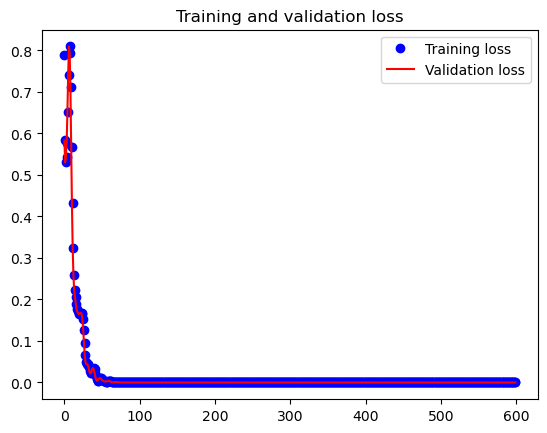

In [49]:
# plot the train&validation loss curve with only one sample
epochs = range(len(train_history))
plt.figure()
plt.plot(epochs, train_history[:,3], 'bo', label='Training loss')
plt.plot(epochs, val_history[:,3], 'r', label='Validation loss')
plt.title('Training and validation loss')

plt.legend()
plt.show()

In [50]:
mynet.eval()
TEST = random.randint (0, 11)
test_in, gt_X, gt_Y, gt_yaw, gt_th, gt_st = over_data[TEST]
test_in = [torch.tensor(x).cuda() for x in test_in]
gt_output = [gt_X, gt_Y, gt_yaw, gt_th, gt_st]
gt_output = torch.tensor(gt_output).to(device)
output_pred = mynet(test_in) 
#print('TEST', TEST)
print('test_in',test_in[1])
print('prediction:{},\nground truth:{}'.format(output_pred.cpu().detach().numpy(), gt_output))

test_in tensor(4.9390, device='cuda:0')
prediction:[[5.270471   3.9836092  0.62367886 1.0000006  0.9999999 ]],
ground truth:tensor([5.2705, 3.9836, 0.6237, 1.0000, 1.0000], device='cuda:0',
       dtype=torch.float64)


/home/melina/.local/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


In [51]:
# start the main training process

num_trainbatch = np.ceil(len(train_data)/32) 
num_valbatch = np.ceil(len(val_data)/32) 
train_history = np.empty([0, 5], dtype=float) 
val_history = np.empty([0, 5], dtype=float) 

min_loss = 100000
current_patience = 0
patience = 5



In [57]:
myoptimizer = optim.Adam(mynet.parameters(), lr=1e-6, eps = 1e-08) 
max_epochs = 50
print('Start training!')
for epoch in range(max_epochs): 
    '''
    if epoch >= 29 and epoch <= 39:
        myoptimizer.param_groups[0]['lr'] = 1e-5
    elif epoch > 39:
        myoptimizer.param_groups[0]['lr'] = 1e-6
    '''
    train_loss1, train_loss2, train_loss3, train_loss4, train_loss5 = run_epoch(model=mynet,criterion=mycriterion,
                           optimizer=myoptimizer,dataloader=train_loader,
                           iftrain=True)
    train_history = np.append(train_history, np.array([[train_loss1, train_loss2, train_loss3, train_loss4, train_loss5]])/num_trainbatch, axis=0)
    val_loss1, val_loss2, val_loss3, val_loss4, val_loss5 =  run_epoch(model=mynet,criterion=mycriterion,
                           optimizer=myoptimizer,dataloader=val_loader,
                           iftrain=False)
    val_history = np.append(val_history, np.array([[val_loss1, val_loss2, val_loss3, val_loss4, val_loss5]])/num_valbatch, axis=0)
    #if epoch % 10 == 9:
    print(f"Epoch {epoch + 1: >3}/{max_epochs}")
    print('Delta X: train_loss: %2e, val_loss: %2e'%(train_history[-1][0], val_history[-1][0]))
    print('Delta Y: train_loss: %2e, val_loss: %2e'%(train_history[-1][1], val_history[-1][1]))
    print('Delta yaw: train_loss: %2e, val_loss: %2e'%(train_history[-1][2], val_history[-1][2]))
    print('Throttle: train_loss: %2e, val_loss: %2e'%(train_history[-1][3], val_history[-1][3]))
    print('Steering Angle: train_loss: %2e, val_loss: %2e'%(train_history[-1][4], val_history[-1][4]))
'''
    # early stopping
    if min_loss == 100000 or val_loss < min_loss :
        min_loss = val_loss
        current_patience = 0
        torch.save(mynet.state_dict(),'mynet.pth')
      
    else :
        current_patience += 1 
        if current_patience >= patience :
            print("Stopping early at epoch {}!".format(epoch+1)) 
            break   '''

print('FINISH.')

Start training!
Epoch   1/50
Delta X: train_loss: 6.874965e-03, val_loss: 8.161874e-02
Delta Y: train_loss: 3.659056e-03, val_loss: 6.113305e-02
Delta yaw: train_loss: 4.833219e-04, val_loss: 1.522152e-03
Throttle: train_loss: 1.821463e-03, val_loss: 3.392555e-02
Steering Angle: train_loss: 1.189624e-03, val_loss: 1.917386e-02
Epoch   2/50
Delta X: train_loss: 6.393266e-03, val_loss: 8.153284e-02
Delta Y: train_loss: 3.424545e-03, val_loss: 6.082876e-02
Delta yaw: train_loss: 4.773171e-04, val_loss: 1.511087e-03
Throttle: train_loss: 1.737024e-03, val_loss: 3.381680e-02
Steering Angle: train_loss: 1.151773e-03, val_loss: 1.915028e-02
Epoch   3/50
Delta X: train_loss: 5.988955e-03, val_loss: 8.143891e-02
Delta Y: train_loss: 3.207452e-03, val_loss: 6.085388e-02
Delta yaw: train_loss: 4.723087e-04, val_loss: 1.504126e-03
Throttle: train_loss: 1.669230e-03, val_loss: 3.386615e-02
Steering Angle: train_loss: 1.119284e-03, val_loss: 1.918039e-02
Epoch   4/50
Delta X: train_loss: 5.611204e-0

KeyboardInterrupt: 

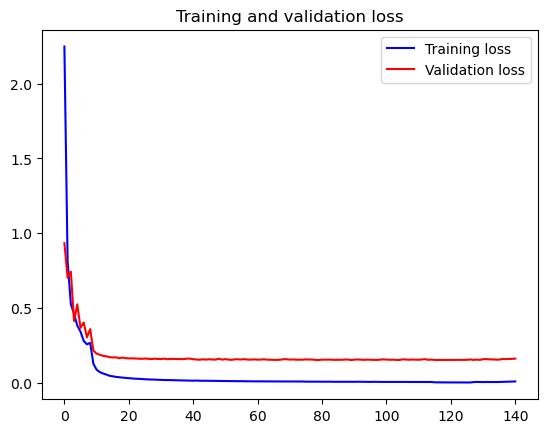

In [72]:
# plot the train&validation loss curve 
epochs = range(len(train_history))
plt.figure()
plt.plot(epochs, train_history[:,0], 'b', label='Training loss')
plt.plot(epochs, val_history[:,0], 'r', label='Validation loss')
plt.title('Training and validation loss')

plt.legend()
plt.show()


In [58]:
# save trained model
torch.save(mynet.state_dict(),'./models/mynet_alex_1.pth')

In [15]:
mynet.load_state_dict(torch.load('./models/mynet_simple_1.pth'))

<All keys matched successfully>

In [59]:
for i in range (21):
    TEST = random.randint (0, 2900)
    test_in, gt_X, gt_Y, gt_yaw, gt_th, gt_st = val_data[TEST]
    test_in = [torch.tensor(x).cuda() for x in test_in]
    gt_output = [gt_X, gt_Y, gt_yaw, gt_th, gt_st]
    gt_output = torch.tensor(gt_output).to(device)
    output_pred = mynet(test_in) 
    #print('TEST', TEST)
    #print('test_in',test_in)
    print('prediction:{}, ground truth:{}'.format(output_pred[:,3:].cpu().detach().numpy(), gt_output[3:].cpu().detach().numpy()))

prediction:[[0.20180774 0.00740812]], ground truth:[0.22825652 0.01198591]
prediction:[[ 0.38047433 -0.06458561]], ground truth:[0.3172086  0.00246053]
prediction:[[ 0.9981288  -0.01455041]], ground truth:[ 1.         -0.08149473]
prediction:[[0.80992866 0.05731828]], ground truth:[0.98859996 0.04723896]
prediction:[[-0.01853594 -0.09389754]], ground truth:[ 1.98382589e-13 -2.01118566e-02]
prediction:[[-0.05176756  0.00249628]], ground truth:[1.43580562e-14 5.54072520e-03]
prediction:[[0.08309838 0.02042792]], ground truth:[1.50902971e-05 5.24200301e-02]
prediction:[[ 0.14169094 -0.0623159 ]], ground truth:[ 0.12143705 -0.03632329]
prediction:[[0.30289507 0.00980852]], ground truth:[0.46432591 0.00847631]
prediction:[[0.28165555 0.01636351]], ground truth:[4.00460310e-06 6.97819681e-02]
prediction:[[ 0.9981288  -0.01455041]], ground truth:[ 1.         -0.08149473]
prediction:[[ 0.408731  -0.9222911]], ground truth:[ 1.93341381e-16 -1.00000000e+00]
prediction:[[0.63473165 0.17228682]], 

/home/melina/.local/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


In [60]:
for i in range (21):
    TEST = random.randint (0, 2900)
    test_in, gt_X, gt_Y, gt_yaw, gt_th, gt_st = val_data[TEST]
    test_in = [torch.tensor(x).cuda() for x in test_in]
    gt_output = [gt_X, gt_Y, gt_yaw, gt_th, gt_st]
    gt_output = torch.tensor(gt_output).to(device)
    output_pred = mynet(test_in) 
    #print('TEST', TEST)
    #print('test_in',test_in)
    print('prediction:{}, ground truth:{}'.format(output_pred[:,:3].cpu().detach().numpy(), gt_output[:3].cpu().detach().numpy()))

prediction:[[7.6231966  1.2463416  0.36152515]], ground truth:[7.68005268 1.2896464  0.33085424]
prediction:[[7.740574  0.3489024 0.1202274]], ground truth:[7.73125087 0.31547991 0.08318976]
prediction:[[ 8.4234915  -0.10904135 -0.03282177]], ground truth:[ 8.41632591 -0.13101208 -0.05037928]
prediction:[[6.314478   3.7126942  0.47694176]], ground truth:[6.23725881 3.68921218 0.49257721]
prediction:[[ 1.2351148e+01 -1.3838485e-02  5.0660670e-03]], ground truth:[1.24483810e+01 2.68044061e-02 5.55455509e-03]
prediction:[[11.325806   -0.14030631 -0.03471857]], ground truth:[11.51552601 -0.28899742 -0.06259574]
prediction:[[10.301918    0.38443768  0.10137194]], ground truth:[10.38774131  0.35287853  0.08975599]
prediction:[[14.760749    0.32737595 -0.04234618]], ground truth:[16.9425874   0.64110132 -0.0376286 ]
prediction:[[ 7.59889    -0.03663762 -0.02172571]], ground truth:[ 7.58857241 -0.0706915  -0.0297073 ]
prediction:[[12.801566    0.7412424   0.09253979]], ground truth:[12.5244400

/home/melina/.local/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


In [69]:
torch.cat((output_pred[0][:3], torch.tensor([1,2]).to(device)), axis = 0)

tensor([11.8419,  0.3709,  0.0354,  1.0000,  2.0000], device='cuda:0',
       grad_fn=<CatBackward0>)

In [67]:
torch.tensor([1]).shape

torch.Size([1])